### Speciteller with sklearn

In [215]:
import argparse
# import liblinearutil as ll

import sys
import os
os.chdir('/Users/saharatif/Hearst pattern extractor/speciteller/')
! pwd

import utils
from features import Space
from generatefeatures import ModelNewText

/Users/saharatif/Hearst pattern extractor/speciteller


In [216]:
!pwd

/Users/saharatif/Hearst pattern extractor/speciteller


In [217]:
def initBrnSpace():
    s = Space(101)
    s.loadFromFile(BRNCLSTSPACEFILE)
    return s

In [218]:
def readScales(scalefile):
    scales = {}
    with open(scalefile) as f:
        for line in f:
            k,v = line.strip().split("\t")
            scales[int(k)] = float(v)
        f.close()
    return scales

In [219]:
def simpleScale(x, trainmaxes=None):
    maxes = trainmaxes if trainmaxes!=None else {}
    if trainmaxes == None:
        for itemd in x:
            for k,v in itemd.items():
                if k not in maxes or maxes[k] < abs(v): maxes[k] = abs(v)
    newx = []
    for itemd in x:
        newd = dict.fromkeys(itemd)
        for k,v in itemd.items():
            if k in maxes and maxes[k] != 0: newd[k] = (v+0.0)/maxes[k]
            else: newd[k] = 0.0
        newx.append(newd)
    return newx,maxes

In [220]:
def getFeatures(fin):
    aligner = ModelNewText(brnspace,brnclst,embeddings)
    aligner.loadFromFile(fin)
    aligner.fShallow()
    aligner.fNeuralVec()
    aligner.fBrownCluster()
    y,xs = aligner.transformShallow()
    _,xw = aligner.transformWordRep()
    return y,xs,xw

In [221]:
def score(p_label, p_val):
    ret = []
    for l,prob in zip(p_label,p_val):
        m = max(prob)
        if l == 1: ret.append(1-m)
        else: ret.append(m)
    return ret

In [222]:
def writeSpecificity(preds, outpath):
    with open(outpath,'w') as f:
        for pred in preds:
            f.write(f"{pred}\n")

In [223]:
# RT = "../"
RT = "/Users/saharatif/Hearst pattern extractor/speciteller/"

BRNCLSTSPACEFILE = RT+"cotraining_models/brnclst1gram.space"
SHALLOWSCALEFILE = RT+"cotraining_models/shallow.scale"
SHALLOWMODELFILE = RT+"cotraining_models/shallow.model"
NEURALBRNSCALEFILE = RT+"cotraining_models/neuralbrn.scale"
NEURALBRNMODELFILE = RT+"cotraining_models/neuralbrn.model"

In [224]:
brnclst = utils.readMetaOptimizeBrownCluster()
embeddings = utils.readMetaOptimizeEmbeddings()
brnspace = initBrnSpace()
scales_shallow = readScales(SHALLOWSCALEFILE)
scales_neuralbrn = readScales(NEURALBRNSCALEFILE)

loading brown clusters...
done; # words:  247339
loading word embeddings...
done; # words:  268810


In [225]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
import numpy as np

In [226]:
with open(SHALLOWMODELFILE, 'r') as f:
    lines = f.readlines()
    
shallow_weights = np.array([[float(line) for line in lines[6:]]])

with open(NEURALBRNMODELFILE, 'r') as f:
    lines = f.readlines()
    
neuralbrn_weights = np.array([[float(line) for line in lines[6:]]])
shallow_weights.shape, neuralbrn_weights.shape

((1, 14), (1, 201))

In [227]:
# ToDo
"""
model_shallow = ll.load_model(SHALLOWMODELFILE)
model_neuralbrn = ll.load_model(NEURALBRNMODELFILE)
"""
model_shallow = LogisticRegression(
    random_state=0, 
    solver='liblinear',
    penalty='l2'
)
model_shallow.classes_ = np.array([-1, 1])
model_shallow.coef_ = shallow_weights
model_shallow.intercept_ = np.array([-1.,])

In [228]:
model_neuralbrn = LogisticRegression(
    random_state=0, 
    solver='liblinear',
    penalty='l2'
)
model_neuralbrn.classes_ = np.array([-1, 1])
model_neuralbrn.coef_ = neuralbrn_weights
model_neuralbrn.intercept_ = np.array([-1.,])

In [229]:
def predict(y,xs,xw):
    xs,_ = simpleScale(xs,scales_shallow)
    xw,_ = simpleScale(xw,scales_neuralbrn)
    # ToDo
    p_label, p_acc, p_val = ll.predict(y,xs,model_shallow,'-q -b 1')
    ls_s = score(p_label,p_val)
    # ToDo
    p_label, p_acc, p_val = ll.predict(y,xw,model_neuralbrn,'-q -b 1')
    ls_w = score(p_label,p_val)
    return [(x+y)/2 for x,y in zip(ls_s,ls_w)],ls_s,ls_w

In [230]:
def getDenseFeatures(X, size):
    new_X = []
    for x in X:
        new_x = []
        for i in range(1, size+1):
            if i in x:
                new_x.append(x[i])
            else:
                new_x.append(0.)
        new_X.append(new_x)
    
    return new_X

In [231]:
! pwd

/Users/saharatif/Hearst pattern extractor/speciteller


In [240]:
# inputfile = '../sents_test'
# outputfile = '../output/sents_test.probs'
inputfile = '/Users/saharatif/Hearst pattern extractor/79_t5_single_sentsum_new.txt'
outputfile = '/Users/saharatif/Hearst pattern extractor/speciteller/spec.prob'
write_all_preds = True

y,xs,xw = getFeatures(inputfile)      #-1 is 0 or gen and 1 is 1 as specific
print(xs[0])
 


{1: 21, 2: 0.0, 3: 0.23809523809523808, 4: 0.047619047619047616, 5: 5.190476190476191, 6: 2, 7: 0.38095238095238093, 8: 0.14285714285714285, 9: 0.047619047619047616, 10: 360.9047619047619, 11: 223.8095238095238, 12: 1.286717, 13: 8.083106, 14: 3.463294416666667}


In [241]:
def predict_sklearn(y, xs,xw, s_size, w_size):
    xs,_ = simpleScale(xs,scales_shallow)
    xw,_ = simpleScale(xw,scales_neuralbrn)
#     print(f"xs: {len(xs)} {len(xs[0])} {len(xs[-1])} {s_size}")
#     print(f"xw: {len(xw)} {len(xw[0])} {len(xw[-1])} {w_size}")
    xs = getDenseFeatures(xs, s_size)
    xw = getDenseFeatures(xw, w_size)
#     print(f"xs-: {len(xs)} {len(xs[0])} {len(xs[-1])} {s_size}")
#     print(f"xw-: {len(xw)} {len(xw[0])} {len(xw[-1])} {w_size}")
    
#     print(model_shallow.coef_)
#     print(np.array(xs).shape)
    
    ys = model_shallow.predict(xs)
    ps = model_shallow.predict_proba(xs)
#     ps_max=np.max(model_shallow.predict_proba(xs),axis=1)
#     print(f"ys: {ys}")
#     print(f"ps: {ps}")
    yw = model_neuralbrn.predict(xw)
    pw = model_neuralbrn.predict_proba(xw)
#     print(f"yw: {yw}")
#     print(f"pw: {pw}")
    
    comb = [(s+w)/2 for s, w in zip(ps, pw)]
#     print(comb)

    return comb, ys, yw

In [242]:

y,xs,xw = getFeatures(inputfile)
preds_comb, preds_s, preds_w = predict_sklearn(
    y,
    xs,
    xw, 
    len(shallow_weights[0]), 
    len(neuralbrn_weights[0])
)

print((preds_comb[0][1]))
print(len(preds_comb))
# writeSpecificity(preds_comb,outputfile)
# print(preds_comb)

# if write_all_preds:
#     writeSpecificity(preds_s, outputfile+".s")
#     writeSpecificity(preds_w, outputfile+".w")

0.13736579707820978
79


In [244]:
for i in range(len(preds_comb)):
    if (preds_comb[i][0]<0.5):
        print("gen: ",preds_comb[i][0])
    else:
        print("spec: ",1-preds_comb[i][1])

spec:  0.8626342029217902
spec:  0.9968107597000857
spec:  0.9803213192946698
gen:  0.28218781817183786
spec:  0.8617973801801109
spec:  0.5495015623592867
spec:  0.9814037219558278
spec:  0.9972944157760468
spec:  0.9403760898580414
spec:  0.9142457914999701
spec:  0.9873874787450343
spec:  0.8925991544740818
spec:  0.9833914174818216
spec:  0.781801441302044
spec:  0.9767897083267627
spec:  0.8210141512047915
spec:  0.9904072015463065
spec:  0.8969464432101981
spec:  0.9950636101585644
gen:  0.44924412755815546
spec:  0.6693726419882576
spec:  0.5268691321292419
spec:  0.9519466706839973
spec:  0.8015635625262982
spec:  0.6600146664535329
spec:  0.997119833718164
spec:  0.5292542935840017
spec:  0.8120119162399172
spec:  0.9662043423164021
spec:  0.9170345884628407
spec:  0.7631755504019611
spec:  0.5209099170085651
spec:  0.9212400494395955
spec:  0.9268788089232254
gen:  0.16750381236388823
spec:  0.9613382042266448
spec:  0.5478792302592244
spec:  0.6337880827590565
gen:  0.479337

In [238]:
# For Hearst pattern extractor/original_summary_with_entities_single_sentence.txt

specificity_summ =[]
for i in range(len(preds_comb)):
    if (preds_comb[i][0]<0.5):
        print(preds_comb[i][0])
        specificity_summ.append(preds_comb[i][0])
    else:
        print(1-preds_comb[i][1])
        specificity_summ.append(1-preds_comb[i][1])
        

0.9999533758636953
0.9999583309896132
0.9977827040535602
0.9995378017897648
0.8788389835447071
0.1876441711219176
0.9953388118897429
0.9999991831541535
0.9978672773783932
0.9969580003870107
0.9947879132937283
0.9424724469059681
0.9899968791312866
0.9979645079825574
0.9997026413263517
0.99188198140626
0.9983115442908228
0.9951646958942818
0.9955117794100318
0.44130185983918485
0.9366472277122391
0.8773844223273708
0.25821164861207635
0.9931006075857971
0.9907920470768781
0.9836074551816001
0.5061663899653127
0.9552106926498768
0.9991215914015271
0.996486823700818
0.8492080823909478
0.8689410367376496
0.9738841298897808
0.9381422357713072
0.7153322525576415
0.23716126389189485
0.5661759083943213
0.9978344252759156
0.7815220747765275
0.17065201004353375
0.8220719151988104
0.31622732755167454
0.4512929536265268
0.7981738858783377
0.982241433125621
0.9050722886010681
0.9992581388773718
0.9980686168576318
0.9998674134483928
0.9986159639183086
0.9421547073718323
0.9987015938940115
0.987935225

In [239]:
len(specificity_summ)

79

In [245]:
#for Hearst pattern extractor/t5_single_sentsum.txt

specificity_t5_summ =[]
for i in range(len(preds_comb)):
    if (preds_comb[i][0]<0.5):
        print(preds_comb[i][0])
        specificity_t5_summ.append(preds_comb[i][0])
    else:
        print(1-preds_comb[i][1])
        specificity_t5_summ.append(1-preds_comb[i][1])

0.8626342029217902
0.9968107597000857
0.9803213192946698
0.28218781817183786
0.8617973801801109
0.5495015623592867
0.9814037219558278
0.9972944157760468
0.9403760898580414
0.9142457914999701
0.9873874787450343
0.8925991544740818
0.9833914174818216
0.781801441302044
0.9767897083267627
0.8210141512047915
0.9904072015463065
0.8969464432101981
0.9950636101585644
0.44924412755815546
0.6693726419882576
0.5268691321292419
0.9519466706839973
0.8015635625262982
0.6600146664535329
0.997119833718164
0.5292542935840017
0.8120119162399172
0.9662043423164021
0.9170345884628407
0.7631755504019611
0.5209099170085651
0.9212400494395955
0.9268788089232254
0.16750381236388823
0.9613382042266448
0.5478792302592244
0.6337880827590565
0.47933740267087716
0.7820296297976752
0.21558192100583184
0.2313679886634531
0.5085770860076404
0.6723535989381291
0.9127169340129143
0.85167421773286
0.9928201095850361
0.9443575413638735
0.98042766537174
0.907873136558908
0.83415106995374
0.9059456070283001
0.78163753907125

In [246]:
len(specificity_t5_summ)

79

In [247]:
import pandas as pd
nyt_df_specificity = pd.DataFrame(list(zip(specificity_summ,specificity_t5_summ)),
               columns =['Hyponym summary specificity','T5 summary specificity'])

In [248]:
nyt_df_specificity

,Hyponym summary specificity,T5 summary specificity
0,0.999953,0.862634
1,0.999958,0.996811
2,0.997783,0.980321
3,0.999538,0.282188
4,0.878839,0.861797
...,...,...
74,0.996743,0.955546
75,0.043859,0.130635
76,0.971162,0.250531
77,0.677732,0.417219


In [157]:
# df_specificity['Difference']=df_specificity['Hyponym summary specificity']-df_specificity['T5 summary specificity']

In [182]:
# df_specificity.to_csv('df_specificity.csv',index= False)
df_specificity

,Hyponym summary specificity,T5 summary specificity
0,0.964525,0.996831
1,0.987285,0.652480
2,0.994367,0.985793
3,0.998478,0.750661
4,0.983478,0.991912
...,...,...
97,0.603694,0.626694
98,0.547684,0.793842
99,0.999890,0.878037
100,0.992616,0.998363


In [253]:
nyt_df_specificity.to_csv('nyt_df_specificity_1.csv',index= False)

In [251]:
nyt_df_specificity

,Hyponym summary specificity,T5 summary specificity
0,0.999953,0.862634
1,0.999958,0.996811
2,0.997783,0.980321
3,0.999538,0.282188
4,0.878839,0.861797
...,...,...
74,0.996743,0.955546
75,0.043859,0.130635
76,0.971162,0.250531
77,0.677732,0.417219


<AxesSubplot:ylabel='T5 summary specificity'>

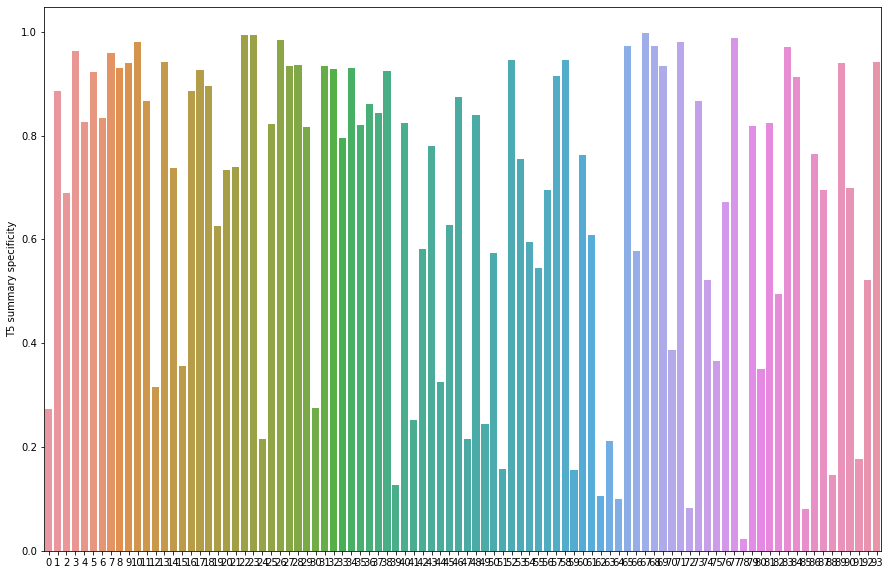

In [214]:
import seaborn as sns
import numpy as np
plt.figure(figsize=(15,10))
sns.barplot(data=cnn_df_specificity,x=cnn_df_specificity.index,y=(cnn_df_specificity['T5 summary specificity']))
# ax.set_yscale('log')
#The more the specificity are near to one the more the log would be near to 0 or less negative. the more the specificity are close to 0 the more the log values would be negative which means many general sentences.

<AxesSubplot:ylabel='Hyponym summary specificity'>

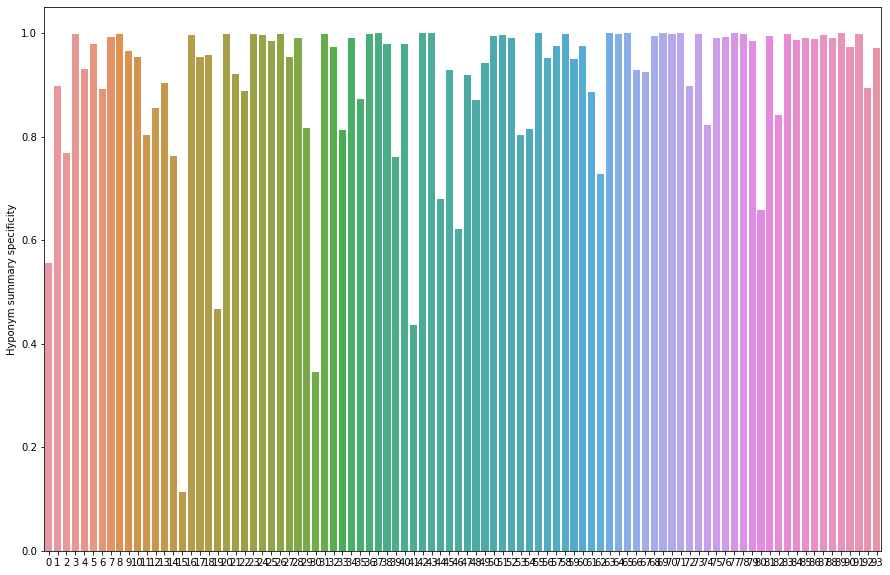

In [213]:
plt.figure(figsize=(15,10))
sns.barplot(data=cnn_df_specificity,x=cnn_df_specificity.index,y=(cnn_df_specificity['Hyponym summary specificity']))

<AxesSubplot:ylabel='Difference'>

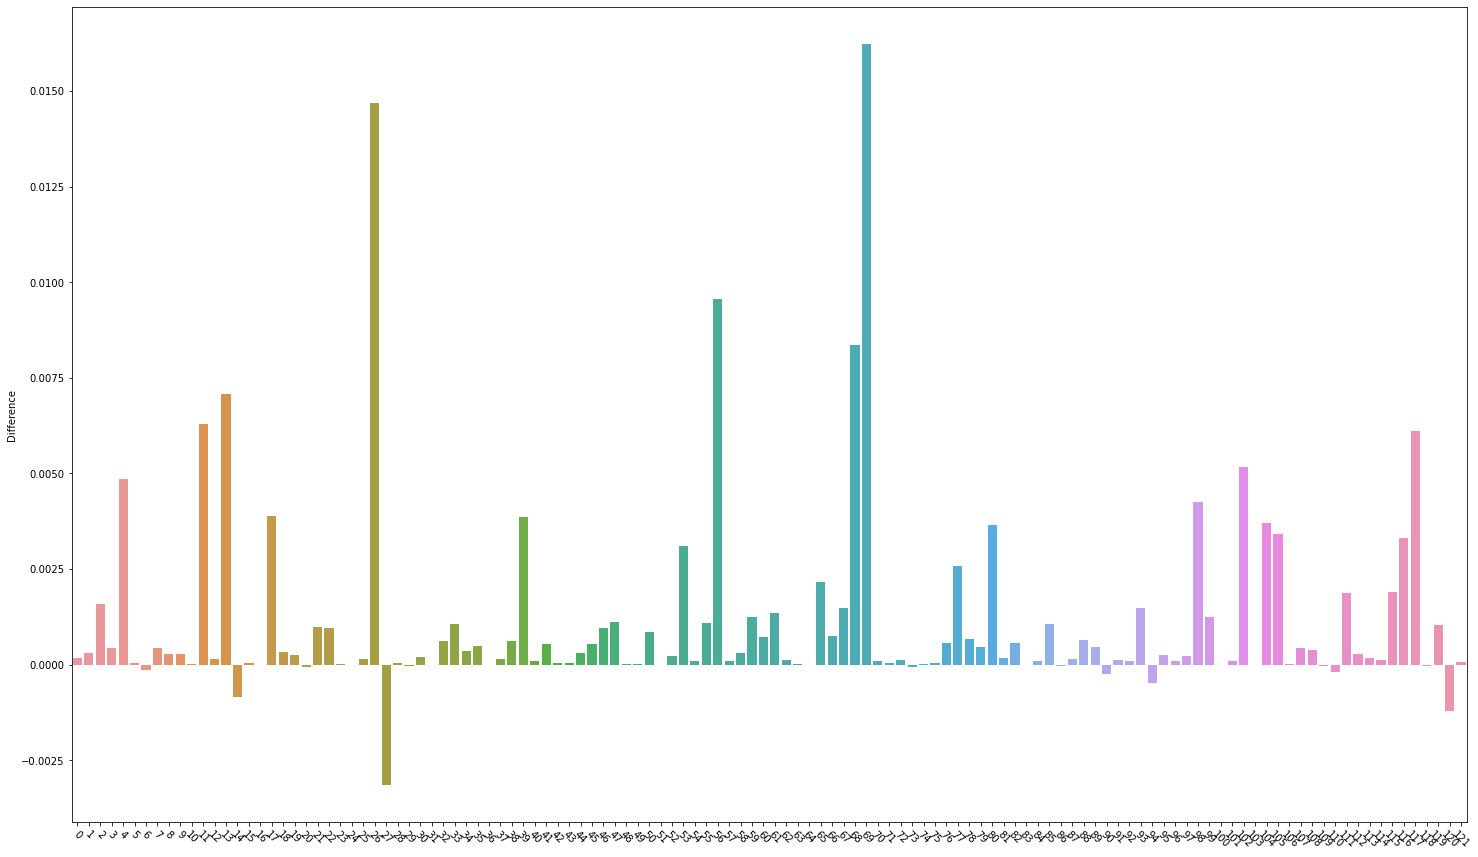

In [80]:
plt.figure(figsize=(25,15))
plt.xticks(rotation = -45) 
sns.barplot(data=df_specificity,x=df_specificity.index ,y='Difference')


In [94]:
df=pd.read_csv('/Users/saharatif/Hearst pattern extractor/Hearst_patterns_nyt-csv-v5.csv')
file= open('original_summaries.txt','w')
for i in df['Summary']:
    file.write(str(i))
    file.write('\n')
file.close()

In [95]:
df_specificity= pd.read_csv('df_specificity.csv')
df_specificity

,Aggregated summary specificity,Revised summary specificity,Difference
0,0.999998,0.999825,0.000172
1,0.999974,0.999672,0.000302
2,0.999920,0.998322,0.001598
3,0.999999,0.999558,0.000441
4,0.999538,0.994691,0.004847
...,...,...,...
117,0.999377,0.993277,0.006100
118,0.999863,0.999909,-0.000047
119,0.999997,0.998965,0.001033
120,0.998745,0.999956,-0.001211


In [22]:
def writeSpecificity(preds, outf):
    with open(outf,'w') as f:
        for x in preds:
            f.write("%f\n" % x)
        f.close()
    print("Output to "+outf+" done.")

In [23]:
! pwd

/Users/saharatif/Hearst pattern extractor/speciteller


In [24]:
def writeSpecificity(preds, outf):
    with open(outf,'w') as f:
        for x in preds:
            f.write("%f\n" % x)
        f.close()
    print("Output to "+outf+" done.")

In [25]:
with open('/Users/saharatif/Hearst pattern extractor/speciteller/test.labels', 'r') as f:
    labels = [line.strip() for line in f.readlines()]
print(len(labels), len(preds_comb))

894 457


In [26]:
cnt_acc = 0
for label, pred, s, w in zip(labels, preds_comb, preds_s, preds_w):
#     print(pred, label, s, w)
    if float(pred[0]) >= float(pred[1]):
        if label == 'spec':
            cnt_acc += 1
    else:
        if label == 'gen':
            cnt_acc += 1
cnt_acc / len(labels)

0.2360178970917226

In [27]:
print(pred)

[0.06098887 0.93901113]


In [25]:
spec_scores = [scores[0] for scores in preds_comb]

In [26]:
sum(spec_scores) / len(spec_scores)

0.6017180936630595

In [27]:
np.std(spec_scores)

0.35331931582861986

ARI

In [169]:
pip install textstat

     |████████████████████████████████| 101 kB 536 kB/s ta 0:00:01
     |████████████████████████████████| 2.0 MB 1.8 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [173]:
test_data = (
    "President George W Bush and his top advisers have warned the iraqi government that continuing funding for military elements of his new iraq strategy will be contingent on prime minister Nuri Kamal al-maliki's delivery on promises to quell violence, officials said."
)

In [174]:
import textstat

In [175]:
print(textstat.automated_readability_index(test_data))

24.8


In [178]:
test_data1= ("""president bush and his top advisers , after nine days of unrelenting criticism from congress , are warning the iraqi government that continuing funding for an american troop increase and other elements of mr. bush 's new iraq strategy will be contingent on prime minister nuri kamal al-maliki ` s delivery on promises to quell violence , senior administration officials said in recent interviews .the warning is coming despite president bush 's declaration , in an interview last weekend , that""")

In [180]:
test_data2= ("""president bush and his top advisers , after nine days of unrelenting criticism from congress , are warning the iraqi government that continuing funding for an american troop increase and other elements of mr.""")

In [181]:
print(textstat.automated_readability_index(test_data2))

20.3


In [ ]:
df=pd.read_csv()